-----
# cartoGRAPHs - FEATURE TUNING

A Notebook to produce 2D and 3D network layouts from any Graph,
including interactive visualization (html files) and export functions 
to import into the VRNetzer analytics platform by Pirch et al.

Please note: 
Large graphs (e.g. 20k nodes / 300k links) can take ~15min using TSNE-based layouts and ~5min using UMAP-based layouts

-----

In [3]:
from cartoGRAPHs import * 

from func_load_data import *
from func_visual_properties import * 
from func_calculations import * 
from func_embed_plot import * 
from func_exportVR import * 

_____
# 1 | DEFINE NETWORK
_____

In [29]:
G = nx.cycle_graph(9)

l_features = ['nodeID:'+str(i) for i in list(G.nodes())]

In [30]:
path = 'output_plots/benchmark/'

In [31]:
edge_opacity = 1
edge_width = 5
node_size = 45
node_width = 3

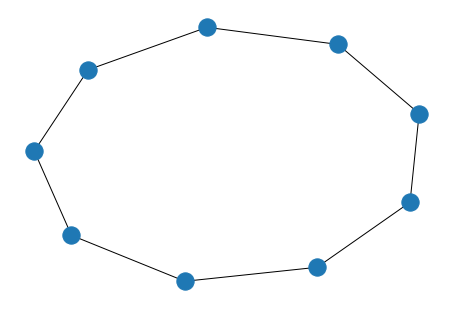

In [32]:
nx.draw(G)

### FUNCTIONAL

In [33]:
scale = 1
val = 0

In [34]:
rows = len(list(G.nodes()))
feat_one = [(val) if i%3 else (scale) for i in range(rows)]
feat_two = [(val) if i%2 or feat_one[i]==scale in feat_one else (scale) for i in range(rows)]
feat_three = [(scale) if feat_one[i]==val and feat_two[i]==val else val for i in range(rows)]
feat_matrix = np.vstack((feat_one,feat_two,feat_three))

In [35]:
feat_matrix

array([[1, 0, 0, 1, 0, 0, 1, 0, 0],
       [0, 0, 1, 0, 1, 0, 0, 0, 1],
       [0, 1, 0, 0, 0, 1, 0, 1, 0]])

In [36]:
# colors based on features 

col_one = 'orange' #'darkblue'
col_two = 'cornflowerblue'
col_three = 'skyblue'

In [37]:
colors_assigned_unsorted = {}
for i,feat in enumerate(feat_matrix):
    if i == 0:
        col = col_one
    elif i == 1:
        col = col_two
    elif i == 2: 
        col = col_three
    for i,v in enumerate(feat):
        if v == 1:
            colors_assigned_unsorted[i]=col
        else:
            pass
        
colors_assigned = {key:colors_assigned_unsorted[key] for key in G.nodes()}

In [38]:
DF_functional = pd.DataFrame(feat_matrix)
DF_functional.index = [100,101,102]

In [39]:
DF_functional

,0,1,2,3,4,5,6,7,8
100,1,0,0,1,0,0,1,0,0
101,0,0,1,0,1,0,0,0,1
102,0,1,0,0,0,1,0,1,0


### STRUCTURAL 

In [40]:
r=0.9
alpha=1.0

A = nx.adjacency_matrix(G)
FM_m_array = rnd_walk_matrix2(A, r, alpha, len(G.nodes()))
DF_structural = pd.DataFrame(FM_m_array).T
DF_structural.index = list(G.nodes())
DF_structural.columns = list(G.nodes()) 

In [41]:
DF_structural

,0,1,2,3,4,5,6,7,8
0,0.904534,0.045340,0.002273,0.000114,0.000006,0.000006,0.000114,0.002273,0.045340
1,0.045340,0.904534,0.045340,0.002273,0.000114,0.000006,0.000006,0.000114,0.002273
2,0.002273,0.045340,0.904534,0.045340,0.002273,0.000114,0.000006,0.000006,0.000114
3,0.000114,0.002273,0.045340,0.904534,0.045340,0.002273,0.000114,0.000006,0.000006
4,0.000006,0.000114,0.002273,0.045340,0.904534,0.045340,0.002273,0.000114,0.000006
5,0.000006,0.000006,0.000114,0.002273,0.045340,0.904534,0.045340,0.002273,0.000114
6,0.000114,0.000006,0.000006,0.000114,0.002273,0.045340,0.904534,0.045340,0.002273
7,0.002273,0.000114,0.000006,0.000006,0.000114,0.002273,0.045340,0.904534,0.045340
8,0.045340,0.002273,0.000114,0.000006,0.000006,0.000114,0.002273,0.045340,0.904534


In [42]:
# normalize DF structural

cols = DF_structural.columns
min_max_scaler = preprocessing.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(DF_structural)
DF_structural_normalized = pd.DataFrame(np_scaled, columns = cols)
DF_structural_norm = DF_structural_normalized.round(6)

### BOTH INTO ONE MATRIX (structural + functional)
+ KEEP RWR ORIGINAL ! > its depending on the "turning point of enhancing factor" estimate 
+ FEATURE MATRIX shall be positioned as addon - columns !! (not rows!!)

In [113]:
scalar = 0.2868

DF_functional_scal = DF_functional*scalar
DF_functional_scal

,0,1,2,3,4,5,6,7,8
100,0.2868,0.0000,0.0000,0.2868,0.0000,0.0000,0.2868,0.0000,0.0000
101,0.0000,0.0000,0.2868,0.0000,0.2868,0.0000,0.0000,0.0000,0.2868
102,0.0000,0.2868,0.0000,0.0000,0.0000,0.2868,0.0000,0.2868,0.0000


In [114]:
DF_merge = pd.concat([DF_structural, 
                      DF_functional_scal]).T

In [115]:
n_neighbors = 3 #int(len(G.nodes()))#*0.75)
spread = 1
min_dist = 0.0 #0
#metric='euclidean'
metric='cosine'

umap2D_merge = embed_umap_2D(DF_merge , n_neighbors, spread, min_dist, metric)
posG_merge = get_posG_2D_norm(G, DF_merge , umap2D_merge)

In [116]:
trace_nodes = get_trace_nodes_2D(posG_merge, list(G.nodes()), color_list, size=node_size, linewidth=node_width)
trace_edges = get_trace_edges_2D(G, posG_merge, color='dimgrey', opac=edge_opacity ,linewidth=edge_width)

data = [trace_edges,trace_nodes]
fname = 'FeatureTuning_merge_FuncScalar'+str(scalar)

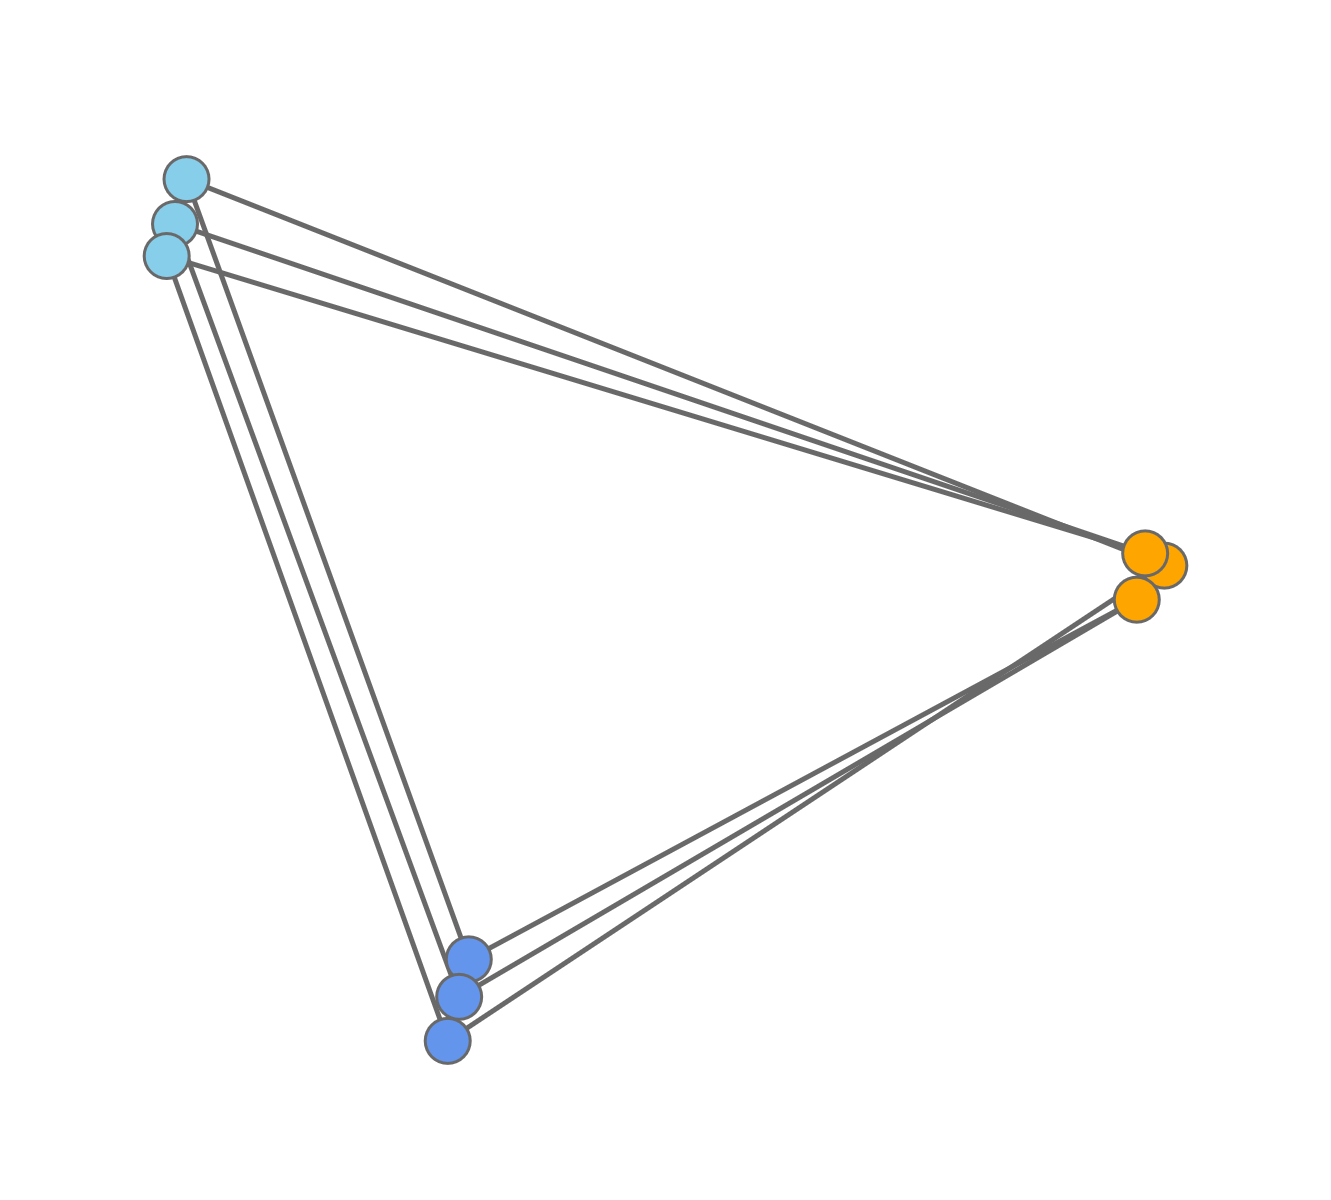

In [117]:
fig = pgo.Figure()
    
for i in data:
    fig.add_trace(i)
        
fig.update_layout(template= 'plotly_white', 
                      showlegend=False, width=1200, height=1200,
                          scene=dict(
                              xaxis_title='',
                              yaxis_title='',
                              xaxis=dict(nticks=0,tickfont=dict(
                                    color='white')),
                              yaxis=dict(nticks=0,tickfont=dict(
                                    color='white')),
                        ))    
fig.update_xaxes(visible=False)
fig.update_yaxes(visible=False)

fig.write_image(path+fname+'_'+'nn'+str(n_neighbors)+'_spr'+str(spread)+'_min'+str(min_dist)+'_'+metric+'_FINAL.pdf')
fig.show()

# How to find the crucial value for the enhancing factor 
### i.e. multiplication factor of struc <> funct turning point 

In [620]:
# 1 | get all values from merged (struc + funct) dataframe 

df_merge_list = DF_merge.values.tolist()
l_merge_all = []
for i in df_merge_list:
    l_merge_all.extend(i)
    
# 2 | get a set of values for x-axis 

set_all_values = set(l_merge_all)

# sort from low to high 
set_all_sorted = sorted(set_all_values)


# 3 | get the count of each value for y-axis 
from collections import Counter

occurrence_counted = Counter(l_merge_all)

occurrence_counted_sorted = {}
for i in set_all_sorted:
    for k,v in occurrence_counted.items():
         if i == k:
            occurrence_counted_sorted[i]=v

### DRAW DIAGRAM 

In [562]:
occurrence_counted_sorted 

{0.0: 9,
 5.996605921048678e-06: 1,
 5.996605921048679e-06: 4,
 5.99660592104868e-06: 2,
 5.996605921048681e-06: 3,
 5.996605921048682e-06: 4,
 5.9966059210486825e-06: 3,
 5.996605921048684e-06: 1,
 0.00011393551249992489: 1,
 0.00011393551249992492: 1,
 0.00011393551249992494: 7,
 0.00011393551249992497: 2,
 0.00011393551249992498: 4,
 0.00011393551249992501: 3,
 0.0022727136440774507: 7,
 0.002272713644077451: 2,
 0.0022727136440774515: 4,
 0.002272713644077452: 4,
 0.0022727136440774524: 1,
 0.0453403373690491: 5,
 0.045340337369049105: 4,
 0.04534033736904911: 4,
 0.04534033736904912: 3,
 0.045340337369049126: 2,
 0.2867105: 18,
 0.9045340337369048: 4,
 0.904534033736905: 5}

In [565]:
x_list = list(occurrence_counted_sorted.keys())
y_list = list(occurrence_counted_sorted.values())

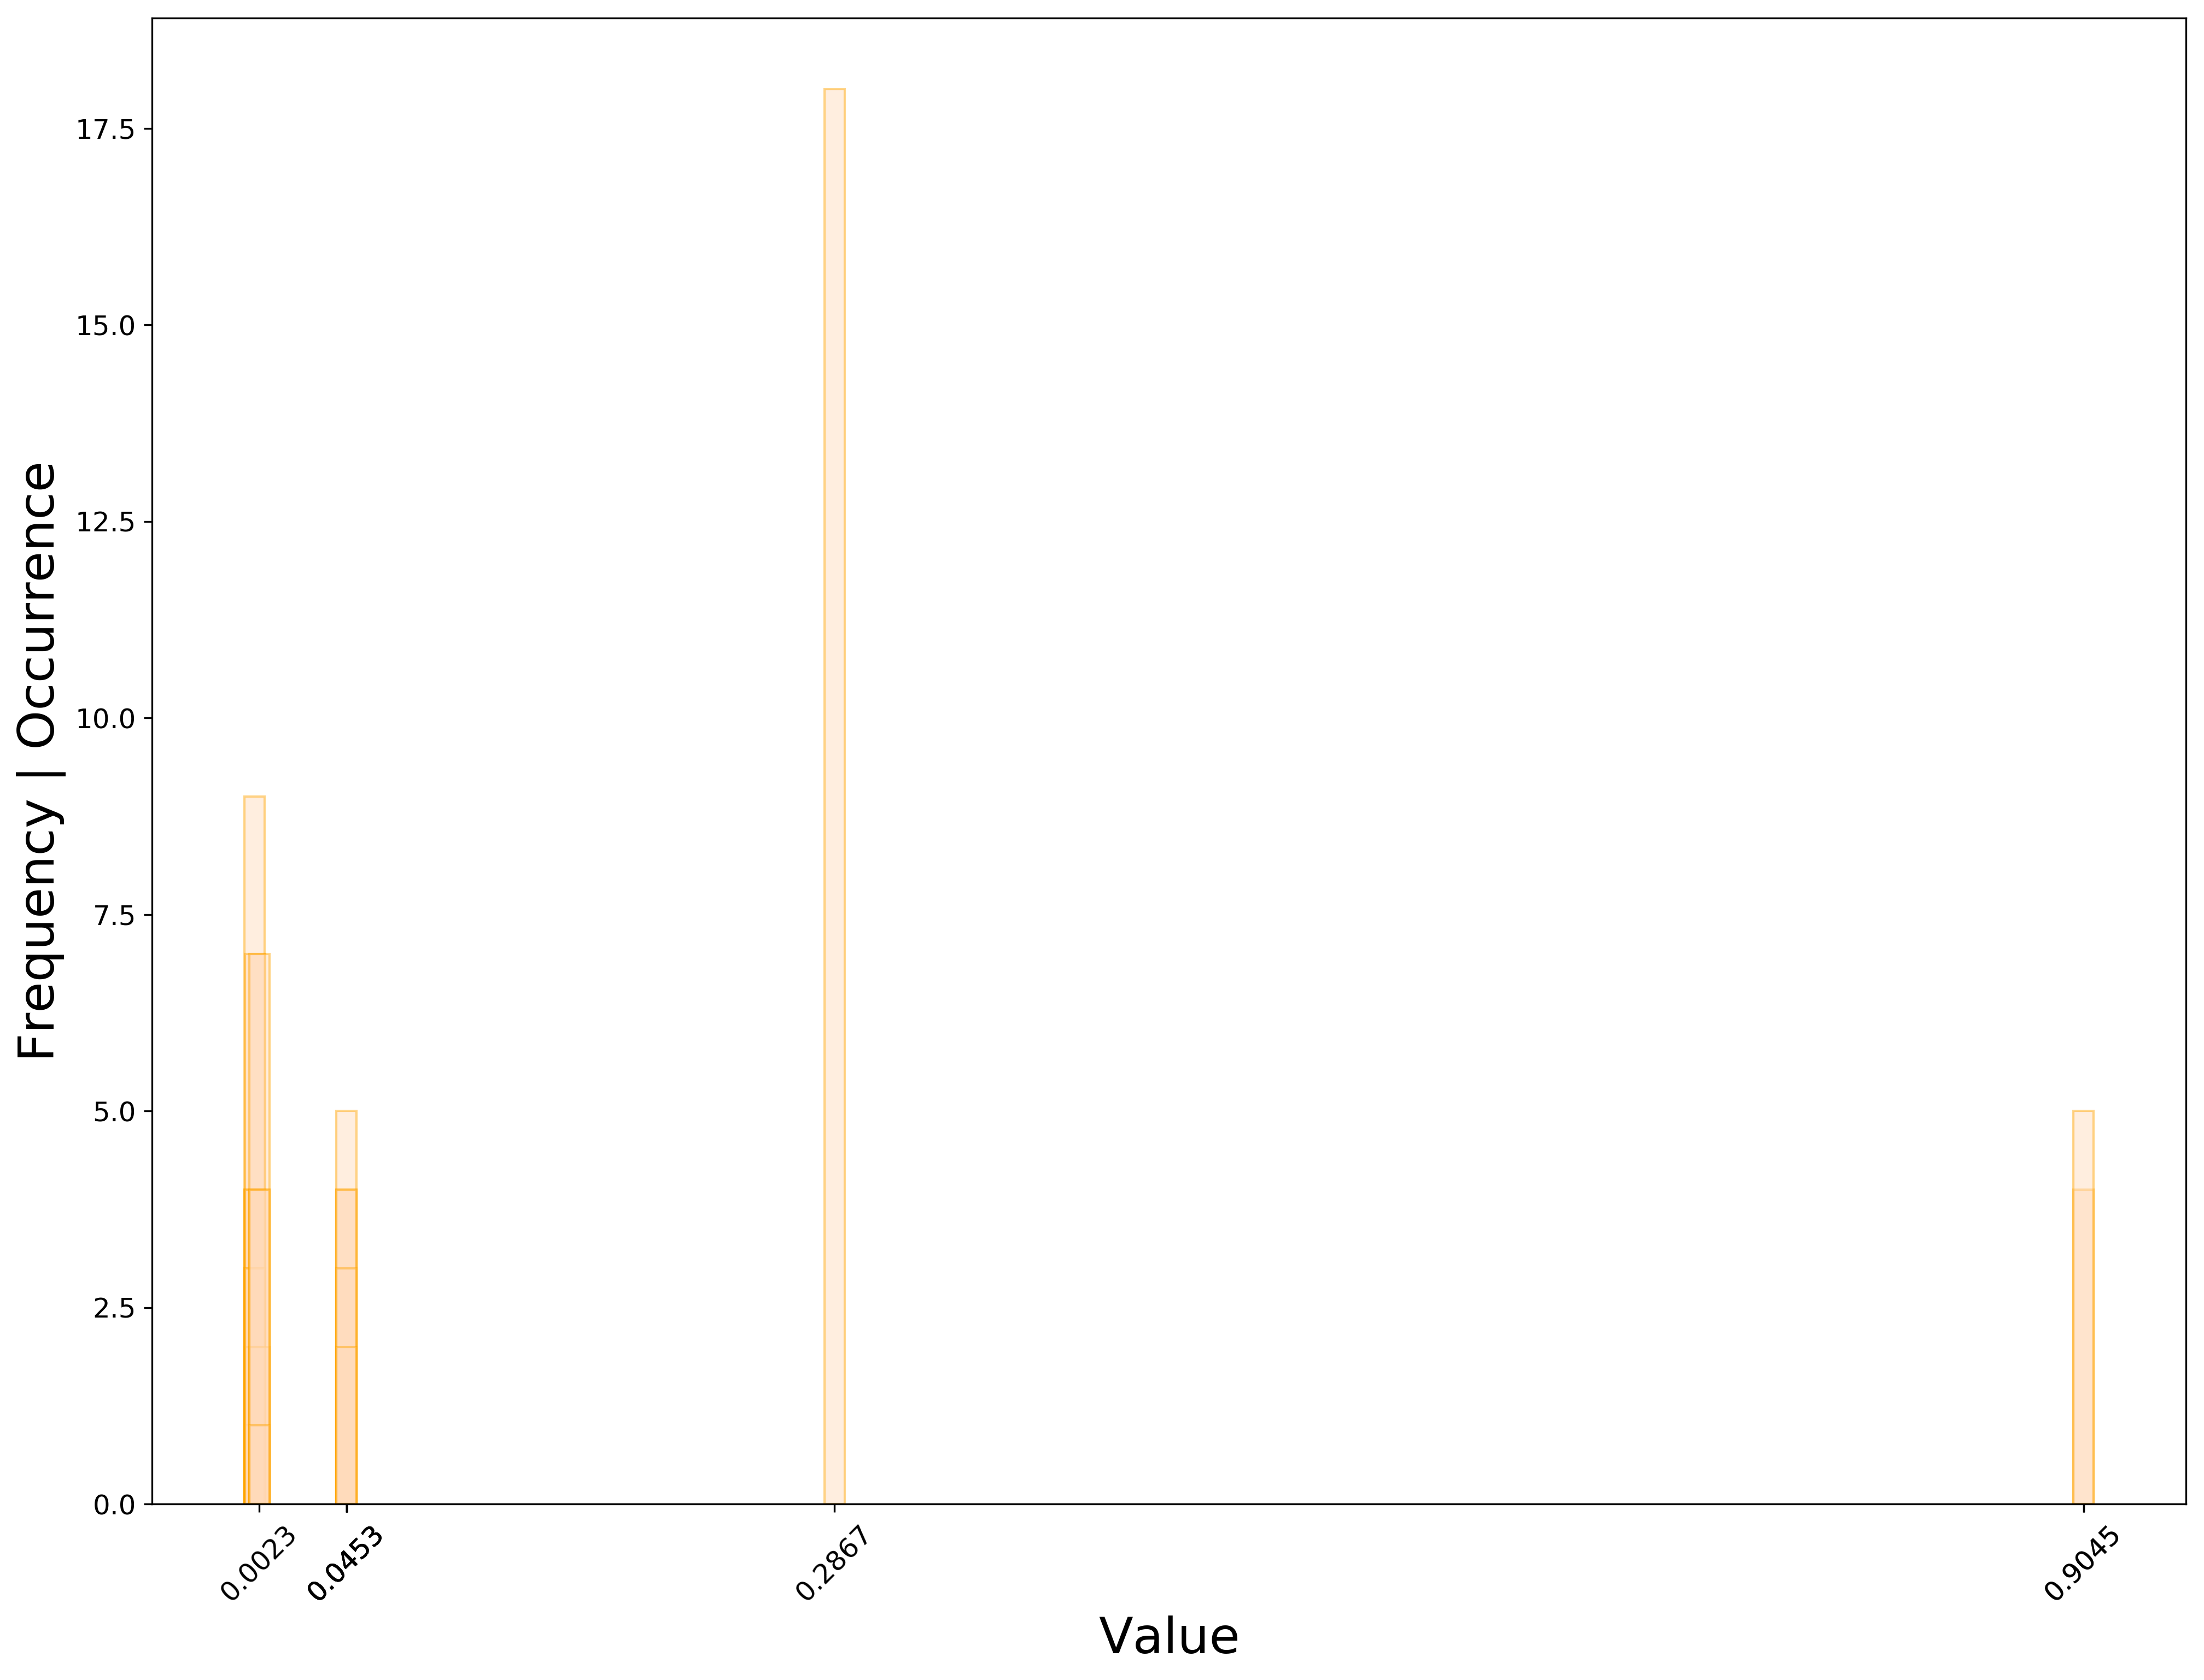

In [583]:
fig, ax = plt.subplots(figsize =(16,12), dpi=300)
plt.bar(x_list,y_list,
        width=0.01,
        edgecolor="orange",
        color='peachpuff',
        alpha=0.45
       )

plt.xlabel('Value', fontsize=22)
plt.ylabel('Frequency | Occurrence', fontsize=22)

plt.xticks(x_list[18:],
    fontsize=12,
    rotation=45
)
plt.yticks(fontsize=12)

#for i,(k,v) in enumerate(occurrence_counted_sorted.items()):
#    if k == max(y_list):
#        plt.text(x_list[i],0, str(x_list[i]), fontsize=10)

fig.savefig('./output_plots/benchmark/Diagram_VisitingProb_ValueFrequency.png')
plt.show()